In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from nn_sparsify_subset_fix_acc import *

plt.style.use("../config/custom_plt.mplstyle")

plt.rc('text', usetex=False)

In [2]:
%%time 

dataset = 'Fashion-MNIST'
hidden_size = [64]

num_samples_per_class = 100000 #1000

# Easy task
# class1 = 2
# class2 = 7
class1 = 3
class2 = 2

activation_fn = '_sigmoid' # or '' for relu

all_original_acc_easy = []
all_results_easy = []

for i in range(20):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    original_acc_easy, results_easy = sparsify_mlp(9, path, [class1, class2], num_samples_per_class,
                                         hidden_size, verbose=False, dataset=dataset)
    all_original_acc_easy.append(original_acc_easy)
    all_results_easy.append(results_easy)

100%|██████████| 38/38 [03:14<00:00,  5.12s/it]

CPU times: user 21h 46min 38s, sys: 23.3 s, total: 21h 47min 1s
Wall time: 32min 41s


In [3]:
%%time

# Hard task
# class1 = 5
# class2 = 7
class1 = 3
class2 = 1
 
all_original_acc_hard = []
all_results_hard = []

for i in range(20):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    original_acc_hard, results_hard = sparsify_mlp(9, path, [class1, class2], num_samples_per_class,
                                                   hidden_size, verbose=False, dataset=dataset)
    all_original_acc_hard.append(original_acc_hard)
    all_results_hard.append(results_hard)

100%|██████████| 38/38 [00:25<00:00,  1.50it/s]

CPU times: user 1d 2h 42min 46s, sys: 25.7 s, total: 1d 2h 43min 11s
Wall time: 40min 8s


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shaded_area(x, data, plot_style='median_iqr', label='', color='blue', alpha=0.2, linestyle='-'):
    """
    Plots a shaded area with a central line based on the provided data.
    
    Parameters:
      x (array-like): x-axis values.
      data (np.ndarray): 2D array where each row corresponds to a run.
      plot_style (str): 'mean_std' for mean ± standard deviation,
                        'median_iqr' for median with interquartile range.
      label (str): Label for the central line.
      color (str): Color for the shaded area and line.
      alpha (float): Transparency for the shaded area.
    """
    if plot_style == 'mean_std':
        central = np.mean(data, axis=0)
        lower = central - np.std(data, axis=0)
        upper = central + np.std(data, axis=0)
    elif plot_style == 'median_iqr':
        central = np.median(data, axis=0)
        lower = np.percentile(data, 25, axis=0)
        upper = np.percentile(data, 75, axis=0)
    else:
        raise ValueError("Unsupported plot_style. Use 'mean_std' or 'median_iqr'.")
        
    plt.fill_between(x, lower, upper, alpha=alpha, color=color)
    plt.plot(x, central, color=color, label=label, linestyle=linestyle)

def extract_values(results, index):
    """
    Extracts values from a list of dictionaries.
    
    Parameters:
      results (list): List of dictionaries with values as iterables.
      index (int): The index to extract from each value tuple.
      
    Returns:
      np.ndarray: 2D array with extracted values.
    """
    vals = []
    for r in results:
        vals.append([x[index] for x in r.values()])
    return np.array(vals)

In [5]:
# colors = [
#   "#a00e00",
#   "#d04e00",
#   "#f6c200",
#   "#0086a8",
#   "#132b69"
# ]

# colors = ["#a00e00", "#132b69"]
# colors = ['#3b7c70', '#ce9642']

colors = ['#ef8a47', '#528fad']

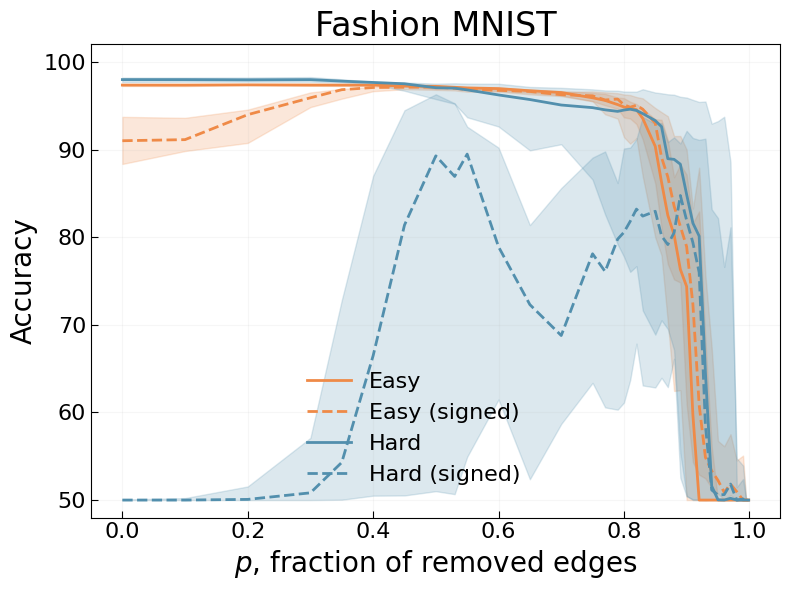

In [6]:
all_fraction_non_zero = np.array(list(all_results_easy[0].keys()))
x = 1 - all_fraction_non_zero  # x-axis: fraction of removed edges

# plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black', label='Easy Original')

vals_original_easy = extract_values(all_results_easy, 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Easy', color=colors[0])

vals_signed_easy = extract_values(all_results_easy, 1)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='Easy (signed)', 
                 color=colors[0], linestyle='--')

# plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
#                  color='black', alpha=0.2)
# plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black', label='Hard original')

vals_original_hard = extract_values(all_results_hard, 0)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='Hard', 
                 color=colors[-1])

vals_signed_hard = extract_values(all_results_hard, 1)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='Hard (signed)', 
                 color=colors[-1], linestyle='--')

plt.legend(loc=(0.3, 0.05))
plt.ylabel('Accuracy')
plt.xlabel('$p$, fraction of removed edges')
plt.ylim(48, 102)

plt.title('Fashion MNIST')

plt.tight_layout()

# plt.savefig("../plots/paper/prune_fashion_mnist_d64.pdf")
# plt.savefig("../plots/paper/prune_fashion_mnist_d32.pdf")
# plt.savefig("../plots/paper/prune_fashion_mnist_d128.pdf")

# plt.savefig("../plots/paper/prune_fashion_mnist_d64_sigmoid.pdf")

In [10]:
hidden_size = [64]

std_weights_hard = []
std_weights_easy = []

for i in range(20):
    class1 = 3
    class2 = 1
    weights_hard = []
    
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}/epoch_9_Layer0_edgelist.txt'    
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_hard.append(float(line.split()[-1]))
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}/epoch_9_Layer1_edgelist.txt'    
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_hard.append(float(line.split()[-1]))

            
    class1 = 3
    class2 = 2
    weights_easy = []
    
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}/epoch_9_Layer0_edgelist.txt'
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_easy.append(float(line.split()[-1]))
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}/epoch_9_Layer1_edgelist.txt'
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            weights_easy.append(float(line.split()[-1]))
       
    std_weights_hard.append(np.std(weights_hard))
    std_weights_easy.append(np.std(weights_easy))

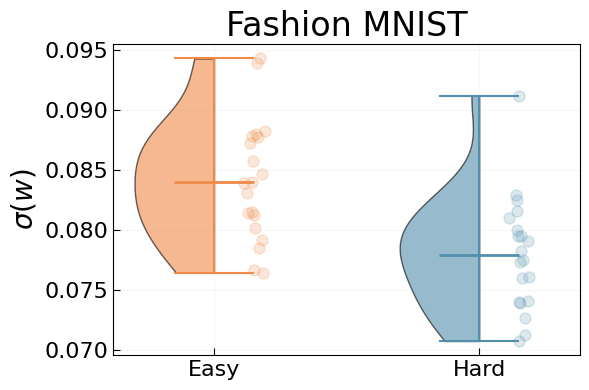

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
positions = [1, 2]

data = [std_weights_easy, std_weights_hard]

for idx, (group, pos, color) in enumerate(zip(data, positions, colors)):
    vp = ax.violinplot([group], positions=[pos], widths=0.6, showmedians=True, showextrema=True)
    body = vp['bodies'][0]
    body.set_facecolor(color)
    body.set_edgecolor('black')
    body.set_alpha(0.6)
    verts = body.get_paths()[0].vertices
    verts[verts[:, 0] > pos, 0] = pos

    # Color median, extrema, and central bar
    vp['cmedians'].set_color(color)
    vp['cmedians'].set_linewidth(2)
    vp['cbars'].set_color(color)
    vp['cbars'].set_linewidth(1.5)
    vp['cmins'].set_color(color)
    vp['cmins'].set_linewidth(1.5)
    vp['cmaxes'].set_color(color)
    vp['cmaxes'].set_linewidth(1.5)
    jitter = np.random.normal(loc=pos + 0.15, scale=0.02, size=len(group))
    ax.scatter(jitter, group, color=color, zorder=3, alpha=0.2)

# Labels and formatting
ax.set_xticks(positions)
ax.set_xticklabels(['Easy', 'Hard'])
ax.set_ylabel(r'$\sigma(w)$')
ax.set_title('Fashion MNIST')

plt.tight_layout()

# plt.savefig("../plots/paper/std_weights_fashion_mnist_d64.pdf")